<a href="https://colab.research.google.com/github/myazdani/pytorch-deep-learning/blob/master/pytorch_chapter_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 4


# Convolutional Neural Networks




- Convolution cell in PyTorch
- Building a CNN to classify  images
- Transfer Learning (NEW)
- Visualizing CNN filters 
- Working with U-Net
- Implementing Image segmentation 
- Implementing Image style transfer 
- Solving the Adding problem with CNNs
- Implementing Sentiment analysis with CNNs


## Convolution in PyTorch

In this section we discuss how the convolution operation works in PyTorch by using 1D convolutions. The same analysis can be extended to higher dimensions.  1D convolutions are especially useful for sequential data such as time series. 

We can think of a convolution layer as a constrained hidden layer. Say the input is  $x\in\mathbb{R}^{n}$, that is it has $n$ elements (such as a time series sequence). As we learned about multi-layered perceptron, the representation of an $m$ dimensional hidden layer $z \in\mathbb{R}^{m}$ can be connected to the input with a fully connected layer that we can specify with the weights $U \in \mathbb{R}^{m \times n}$ and a bias term $b_{u} \in \mathbb{R}^{m}$.  Using matrix multiplication we can write as $z = \sigma(Ux + b_u)$, wherer $\sigma(\cdot)$ is a non-linearity such as the $\tanh$ function. To make the intuition behind the relationship between the convolution layer and the fully connected layer we will ignore the bias term and the non-linearity as these terms just make the notation more cluterred and distract us from the main concepts involved. 

So when we ignore the bias term and the non-linearity, then the hidden layer $z$ can be expressed simply as the matrix multiplication $z = Ux$.


The fully-connected hidden layer weights can be expressed as matrix explicitly as:


$U = \begin{bmatrix}
u_{1,1} & u_{1,2} & \ldots & u_{1,m}\\ 
u_{2,1} & u_{2,2} & \ldots & u_{2,m}\\ 
\vdots &  \vdots & \ddots & \vdots\\ 
u_{m,1} & u_{m,2} & \ldots & u_{m,n}
\end{bmatrix}$

$u_{i,j}\in \mathbb{R}$ can be any scalar and take on any value. The convolution operation for a single convolution kernel places specific constraints on these weights so that the weight matrix is of toeplitz form. When we have multiple convolution kernels, then these toeplitz matrices are stacked up. It is easiest to explain this with a specific example.

Imagine we have inputs $x \in \mathbb{R}^{7}$ and we have a fully connected layer with $𝑚=5$ hidden units so for $z \in\mathbb{R}^{5}$ with weights$U \in \mathbb{R}^{5 \times 7}$. Then each of the hidden units can be expressed as

$z_1 = \sum_{i=1}^{7} u_{1,i}x_{i}$

$z_2 = \sum_{i=1}^{7} u_{2,i}x_{i}$

and so on until

$z_5 = \sum_{i=1}^{7} u_{5,i}x_{i}$

More simply in matrix notation this would be

$z =  \begin{bmatrix}
u_{1,1} & u_{1,2} & \ldots & u_{1,m}\\ 
u_{2,1} & u_{2,2} & \ldots & u_{2,m}\\ 
\vdots &  \vdots & \ddots & \vdots\\ 
u_{m,1} & u_{m,2} & \ldots & u_{m,n}
\end{bmatrix} x$

Let’s now consider what $z_1, z_2, \ldots, z_5$ would look like for a convolution kernel with 3 weights and stride 1. Visually, this looks as follows (example modified slightly from [CS231](http://cs231n.github.io/convolutional-networks/))

![alt text](https://qph.fs.quoracdn.net/main-qimg-dd191c8cffff8090d19bc0eb176c05a0.webp)


$z$ can be equivalently expressed as a computing a fully connected hidden layer but with lots of zeros in the off-diagonal. This weighting matrix will look look as follows:

$z = \begin{bmatrix}
w_1 & w_2 & w_3 & 0 & 0 & 0 & 0\\ 
0 & w_1 & w_2 & w_3 & 0 & 0 & 0\\ 
0 & 0 & w_1 & w_2 & w_3 & 0 & 0\\ 
0 & 0 & 0 & w_1 & w_2 & w_3 & 0\\ 
0 & 0 & 0 & 0 & w_1 & w_2 & w_3
\end{bmatrix}x$

Here I have expliclity written each term in the weighting matrix, but of course in practice we do not actually for a matrix like this to perform convolutions since it would be inefficient. Notice that the matrix has the same shape as the fully connected layer: 5 rows and 7 columns. But whereas the fully-connected layer had 7*5 = 35 weights (all the  $𝑢_{𝑖,𝑗}$ terms), the convolution kernel only has 3 weights $𝑤_1, 𝑤_2, 𝑤_3$.

This is just for one convolution kernel. You can imagine performing this operation for many such kernels and stacking each kernel. In a similar way that you can make the fully connected layer project to arbitrarily high dimensional vector spaces to arbitrarily approximate any function, a similar argument can be made here.


## Example Data Set

A 1D sequence would just be a series of measurements over time. We will consider a popular example used to illustrate such data sets: the  Mauna Loa CO2 dataset. This dataset is the monthly average atmospheric CO2 concentrations (in parts per million by volume (ppmv)) collected at the Mauna Loa Observatory in Hawaii, between 1958 and 2001.

We will use some helper functions from Scikit-Learn to load the dataset. Scikit-learn provides a convinient `datasets` library that allows us to download popular datasets with the `fetch_openml` module. We will also use the function `load_mauna_loa_atmospheric_co2` function as a convinient way for downloading and return the data in NumPy arrays. 

In [0]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import fetch_openml

def load_mauna_loa_atmospheric_co2():
    ml_data = fetch_openml(data_id=41187)
    months = []
    ppmv_sums = []
    counts = []

    y = ml_data.data[:, 0]
    m = ml_data.data[:, 1]
    month_float = y + (m - 1) / 12
    ppmvs = ml_data.target

    for month, ppmv in zip(month_float, ppmvs):
        if not months or month != months[-1]:
            months.append(month)
            ppmv_sums.append(ppmv)
            counts.append(1)
        else:
            # aggregate monthly sum to produce average
            ppmv_sums[-1] += ppmv
            counts[-1] += 1

    months = np.asarray(months).reshape(-1, 1)
    avg_ppmvs = np.asarray(ppmv_sums) / counts
    return months, avg_ppmvs

_, y = load_mauna_loa_atmospheric_co2()

There are many features associated with this dataset but for our example we only look the measurement of the CO2 levels stored in the array `y`. Let's take a look at this dataset. 

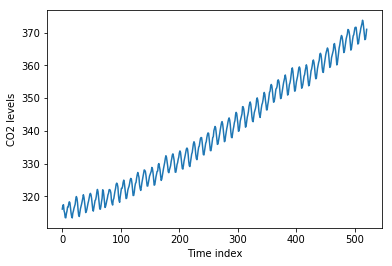

In [0]:
plt.plot(y)
plt.xlabel("Time index")
plt.ylabel("CO2 levels");

We can see that over time the CO2 levels are rising. Let's consider a shorter sample of this signal to demonstrate how a convolution will operate on this signal. We will take the last 2 measurements.

In [0]:
y_sample = y[-2:]
y_sample

array([369.375, 371.02 ])

We will perform a convolution on this small sample to understand how the convolution operation affects it. Below we will instantiate a 1D convolution object `conv_layer` with the `nn.Conv1d` class. 

In [0]:
import torch
import torch.nn as nn

conv_layer = nn.Conv1d(in_channels=1, out_channels=1, stride = 1,
                       kernel_size=2, padding = 0)


When creating a convolution layer, we need to specify several parameters:
- `in_channels` : the number of input "channels" the input data will have. For our single 1D sequence, there is only 1 channel. If we had *two* sequences running in parallel, such as the levels of CO2 *and* the levels of CO in the atmosphere, then we would have to specify to PyTorch that there will be two channels in the data. An important distinction between data across channels and data across the sequence is that the relationship between data across channel is neither spatial nor temporal. Data streams across channels are meant to be *independent* measurements, however the data may still be correlated. Think of the red, green, and blue channels in color images.The red channel in an image is just the amount of red (typically between 0 and 255) each pixel holds and similarly the green channel is the amount of green in each pixel (and similarly for blue). While measuring the amount of red is "independent" from the green or blue channels, there still is a significant correlation between them as how the colors influence how an object appears is a key feature. 
- `out_channels`: this specifies how many convolution filters (also referredt o as kernels) we want to use. In our case we have specified `out_channels = 1`, meaning that we will be only using *one* convolution filter. Of course, we are free to have more than just one convolution and often we will use more than one.
- `stride` : by how many samples should the convolution kernel move across the data. As we have specified `stride = 1` in our example, the kernel will move one sample at a time across the data. If we had specified `stride = 2` then the kernel would skip one sample. 
- `kernel_size` : the width of the convoluition kernel. We can think of the kernel as a small feature (ie, pattern) template that is used to move across the data for detection (by way of similarity measurement). The size of the kernel specifies the size of the pattern template that we seek. Typically, this pattern is much smaller than the size of the input data. The kernel size also specifies the number of parameters that we have to learn for each output channel. For our case, we have `kernel_size = 2` and `out_channels = 1` so we will have to learn 2 parameters corresponding to the kernel plus the additional bias term (so 3 total parameters are adjustable). 


While the kernel is typically learned, we can also specify its values manually. For example, lets set the weights of the kernel to all be $\frac{1}{n}$ where $n$ is the size of the kernel and we will set the bias term to be zero. 

In [0]:
conv_layer.weight.data = ((1/len(conv_layer.weight.data.squeeze()))*
                          torch.ones_like(conv_layer.weight.data))
conv_layer.bias.data = torch.zeros_like(conv_layer.bias.data)

In this very special case, the convolution operation does something that is popular in signal processing: the convolution operation for these weights will perform a *moving average.* Moving averages are popular in signal processing because often there is undesirable high frequency noise in the sigal The moving average will filter out this high frequency noise and smooth the signal. 

In [0]:
y_sample_smoothed = conv_layer(torch.tensor(y_sample, dtype = torch.float32).view(1,1,-1))
y_sample_smoothed

tensor([[[370.1975]]], grad_fn=<SqueezeBackward1>)

The moving average will take the average of contiguous window over the entire sequence. Manually over one window in NumPy if we want to compute a moving average we would have to do something like this:

In [0]:
np.mean(y_sample[0:2])

370.1975

As you can see the convolution operation and manual computation with NumPy are the same. Below we extend our hand crafted convolution to the entire signal and compare with the original:

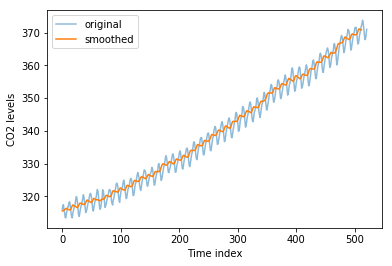

In [0]:
conv_layer = nn.Conv1d(in_channels=1, out_channels=1, stride = 1,
                       kernel_size=10, padding = 0)

conv_layer.weight.data = ((1/len(conv_layer.weight.data.squeeze()))*
                          torch.ones_like(conv_layer.weight.data))
conv_layer.bias.data = torch.zeros_like(conv_layer.bias.data)



y_smoothed = conv_layer(torch.tensor(y, dtype = torch.float32).view(1,1,-1))

plt.plot(y, label = "original", alpha = .5)
plt.plot(y_smoothed.detach().numpy().squeeze(), label = "smoothed")
plt.xlabel("Time index")
plt.ylabel("CO2 levels")
plt.legend();

As you can see, the signal passed through the convolution is a "smoothed" version of the input signal as we expect.

In some applications, smoothing the signal is vital. In addition to smoothing, for many applications we would also like to know the first derivative of the signal. In that case we can specify the convolution parameters to be `[1, -1]`. In general however specifying what the kernel should be is challenging. We therefore would prefer to *learn* what kernels we ought to use in our applications. 

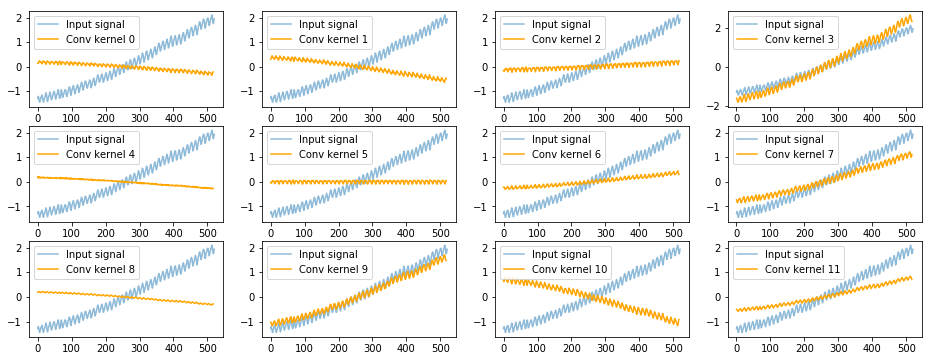

In [0]:
conv_layer = nn.Conv1d(in_channels=1, out_channels=12, stride = 1,
                       kernel_size=4, padding = 0)


conv_layer.bias.data = torch.zeros_like(conv_layer.bias.data)



y_smoothed = conv_layer(torch.tensor((y - np.median(y))/np.std(y), dtype = torch.float32).view(1,1,-1))
plt.figure(figsize=(16,6))
for i in range(12):
    plt.subplot(3,4,i+1)

    plt.plot((y - np.median(y))/np.std(y), label = "Input signal", alpha = .5)
    plt.plot(y_smoothed[0,i,:].detach().numpy().squeeze(), color = "orange",
             label = "Conv kernel " + str(i))
    plt.legend();

## The MNIST dataset


We will use the MNIST dataset as an example image data set to understand many Convolutional Neural Network concepts. The MNIST dataset consists of 28-by-28 pixel grayscale images of hand written digits. MNIST is a great dataset for understanding different ML algorithms since its small and it is easy to understand: the 10 categories corresponding to the digits from 0 to 9  are comprehensible by everyone (unlike knowing the different breeds of dogs in ImageNet). 

Because this dataset is so popular, PyTorch provides an API from the `datasets` module to directly access the MNIST dataset. Let's download the training and test datasets. Since to use PyTorch we require the images to be PyTorch tensors, we can use the `transforms` module from `torchvision` to convert the images. This transformation is specified as the `transforms.ToTensor()` and we pass it to the `transform` argument. Other arguments for `datasets.MNIST` are:

- `root`: where we would like to download the data set
- `train`: whether we want to download the train or test dataset. When set to `True`, we download the train set otherwise the test set.
- `download`: whether we should download the dataset from the internet or not. If you have already downloaded the dataset, you do not need to set this to `True`.


Having defined the training and test set data objects, we can create data loaders that will iterate through batches of inputs (images) and outputs (labels). Let's specify a batch size of 128.


In [0]:
from torchvision import datasets
from torch.utils.data import DataLoader


from torchvision import transforms

import torch.nn.functional as F


training_set = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

testing_set = datasets.MNIST(root='data', 
                             train=False, 
                             transform=transforms.ToTensor())



batch_size = 128

train_loader = DataLoader(dataset=training_set, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=testing_set, 
                         batch_size=batch_size, 
                         shuffle=False)

`train_loader` and `test_loader` are both iterators that go through the data sets 128 examples at a time. Let's check to make sure that one batch meets our expectations. 

In [0]:
images, labels = next(iter(train_loader))  
print("Batch of images:", images.size())


Batch of images: torch.Size([128, 1, 28, 28])


Indeed from the first dimension of the tensor we see that we have 128 examples. The second dimension of the tensor indicates that we have grayscale images and so just one channel. If we had color images in RGB, then we would expect to see 3. The last two dimensions indicate the width and height of the images. As expected for MNIST, we have 28-by-28 pixel images. 

We can similarly check the size of the labels

In [0]:
print("Batch of labels:", labels.size())

Batch of labels: torch.Size([128])


Since the labels are just scalars correspondings to the digits 0 through 9, we see that the labels are just a single dimensional tensor with 128 elements corresponding to the batch size. 

Let's take a look at one of the images with MatplotLib:

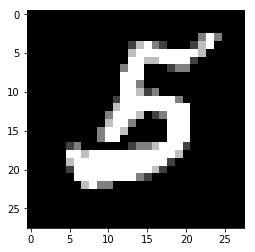

In [0]:
plt.imshow(images[0].numpy().squeeze(), 
           cmap='gray', vmin=0, vmax=1);

## Understanding Feature Maps


Let’s again review some of the key concepts behind a single convolution. A single convolution operation consists of a “kernel” that we can think of as a template or a pattern that we want to match in our input data. The convolution operation sweeps this kernel across the entire input to detect all the locations this pattern occurs in the input. What we get from this is a “feature map” meaning that we have a “map” telling us where the feature (associated with the kernel/template/pattern) occurs in the input. 

If we only have one feature/template/kernel then we will only have one feature map. However we know that most input data that we have consists of many different types of patterns. So trying to detect only one feature in our input is very restrictive.  It therefore makes sense to have not just one convolution kernel but many. In other words we don’t want to just look for one type of pattern in our input, but many. By having multiple convolutions then we will be creating not just a single feature map for one feature but a collection of feature maps for many features. 

Now how many feature maps do we need? Just as the number of hidden units in a fully connected layer in multi-layer perceptrons is a hyper-parameter here too we have a hyper-parameter. Because we will be building multiple layers of features, the deep layer features will correspond to complex patterns that interact with each other.


Let's create 16 convolutions with a kernel size of 3 in both width and height and a stride of 1. 

In [0]:
conv_layer = torch.nn.Conv2d(in_channels=1, out_channels=16,
                             kernel_size=(3, 3),stride=(1, 1),
                             padding=1) # (1(28-1) - 28 + 3) / 2 = 1


feature_maps = conv_layer(images)

 Below we show what different feature maps we have calculated. The weights of these kernels are all random but even then we can see that different types of features are captured.

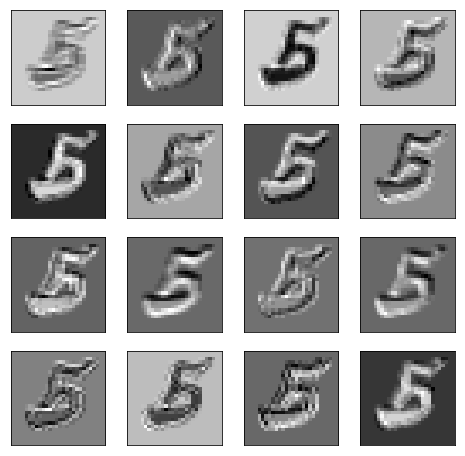

In [0]:
plt.figure(figsize=(8,8))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(feature_maps[0,i,:,:].detach().numpy(), cmap='gray');
    plt.xticks([], [])
    plt.yticks([], [])

To understand better the relationship between kernel size and stride, below we show the different types of feature maps we can create for varying kernel sizes and stride lengths.  We will also specify the kernel weights to all be equal for easier comparison between different. If we don't do this then we will have random feature maps.

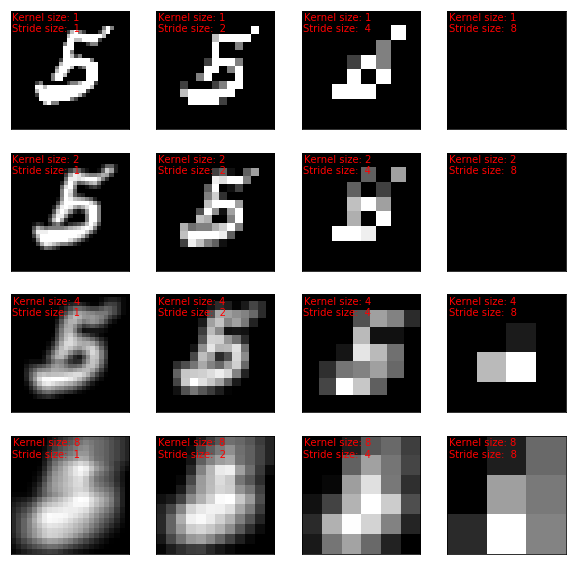

In [0]:
plt.figure(figsize=(10,10))
count = 0
for i in range(4):
    for j in range(4):
        conv_layer = torch.nn.Conv2d(in_channels=1, out_channels=1,
                             kernel_size=(2**i, 2**i),stride=(2**j, 2**j),
                             padding=1) # (1(28-1) - 28 + 3) / 2 = 1
        
        
        conv_layer.weight.data = ((1/conv_layer.weight.data.size()[-2]*conv_layer.weight.data.size()[-1])*
                                  torch.ones_like(conv_layer.weight.data))
        conv_layer.bias.data = torch.zeros_like(conv_layer.bias.data)

        feature_maps = conv_layer(images)
        ax = plt.subplot(4,4,count+1)
        plt.imshow(feature_maps[0,0,:,:].detach().numpy(), cmap='gray');
        plt.xticks([], [])
        plt.yticks([], [])
        count+=1
        #plt.title()
        plt.text(.3, .89,"Kernel size: " + str(2**i) + "\nStride size:  " + str(2**j), 
                 color = "r",
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes)

        

The top-left case corresponding to a kernel size of 1 and a stride length of 1 is a a special case. In this case, all that happens is every pixel in the image is scaled by the kernel parameter (only one value) and then the bias term is added. In this case the size of the output feature map is the same as the size of the input image and because we set the bias term to zero and the kernel weight to be 1, the feature map is the same exact image! In general, however, we would have a scaled image.

As we increase the size of the kernel, we see that the image is "blurred." Generally speaking, the larger the kernel size the blurrier the feature map, however the exact features that pop up depend on the kernel weights. Since we set the kernels to all be equal in this case, we are effectively applying a smoothing window across the image. This why the bottom left most figure appears as a very blurry image. 




## Understanding Max Pooling


Let’s review again what the convolution layer does. The convolution layer consists of a kernel that you can think of as a small template - for example, an edge oriented at 45 degrees North-West. The convolution layer will go through each section of the input image to detect where in the image a 45-degree-edge is located. Every where the image contains a similar edge that is at 45 degrees, the kernel is matched. After the convolution kernel has swept the entire image, we essentially have now a “new image” where each pixel value tells us how much of the 45 degree edge is contained in the different parts of the image. This output is often called a “feature map.”

While the feature map tells us the exact image location where the 45-degree-edge is located, in many applications we do not necessarily care about the very precise location of such edges. All we need to know is roughly where different matched patterns exist with respect to each other. Furthermore, we may actually want to be robust to small changes in object location. In other words, we don’t want the feature map to change drastically if we shift the objects in the image slightly. 


A pooling layer is a popular remedy to satisfy these conditions. A pooling layer downsamples the feature map so that the dimensions are smaller. The benefits of this downsampling are two fold. First, we reduce the dimensions which allows us to have less parameters to learn in the network (typically images can be very large). Second, by downsampling we are making the network robust against small location changes and are emphasizing that relative locations of the features are what matters as opposed to their exact location in the image itself. These advantages of Pooling has made them popular in image processing applications. 

Two pooling operations are popularly used: max pooling and average pooling. An example of max pooling is shown below:
![alt text](https://computersciencewiki.org/images/8/8a/MaxpoolSample2.png)


In this example, we sweep through collections of 4-by-4 regions in the feature map and take the max in each 2-by-2 sub-region.  Recall that when the value of the feature map is “large” that means a feature has been detected. The intuition with max pooling then is we do not necessarily care in which 4-by-4 region the feature is maximally detected. Just approximately where in relative to the other locations.  Average pooling is similar where the average value is taken. 


Let's take a look at what Max-Pooling does to images. Similar to convolution, we can select the "kernel size" and the "stride" length of the Max Pooling operation. The kernel size determines the dimensions of the patch we want to operate on. In the toy example above, the kernel size is 2-by-2 corresponding to the 2-by-2 sub-images that we take the max operation. Of course, since have two dimensions for an image we need to specify the kernel width and height. The stride specifies by how much we want to move the max operation by. In our example above the stride was 2. The smallest stride we can have is 1. To understand better how Max Pooling works on an image, below is an example of how the kernel size and the stride length impact the input image. 

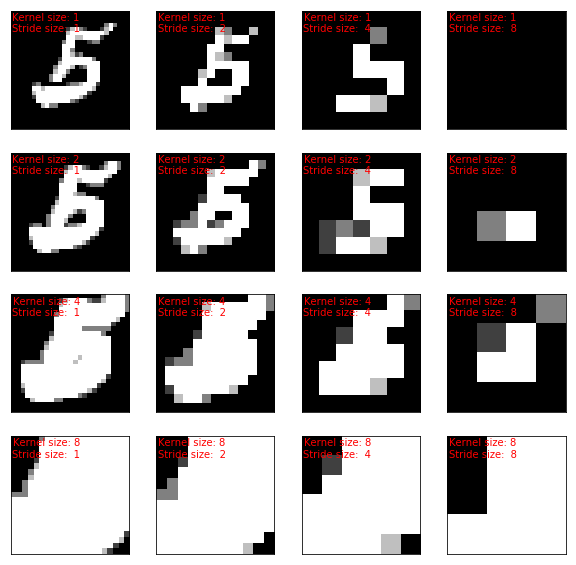

In [0]:
plt.figure(figsize=(10,10))
count = 0
for i in range(4):
    for j in range(4):
        pool_layer = torch.nn.MaxPool2d(kernel_size=(2**i, 2**i),
                                         stride=(2**j, 2**j),
                                         padding=0) # (2(14-1) - 28 + 2) = 0 
        
        feature_maps = pool_layer(images)
        ax = plt.subplot(4,4,count+1)
        plt.imshow(feature_maps[0,0,:,:].detach().numpy(), cmap='gray');
        plt.xticks([], [])
        plt.yticks([], [])
        count+=1
        #plt.title()
        plt.text(.3, .89,"Kernel size: " + str(2**i) + "\nStride size:  " + str(2**j), 
                 color = "r",
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes)

        

Kernel 1 and stride 1 doesn't do anything to do the image but as you increase the kernel size and stride length you lose more information about the image. The case when the kernel size and stride length are 8 results in a 3-by-3 pixel image. In this case, the content of the image is completely lost. 

## Building a CNN to classify images


The CNN is most popularly applied for computer vision applications. In this section we will look at using CNNs for the classification of MNIST images. The task is we have 28-by-28 pixel images that contain a single handwritten digit that's between "0" and "9". 

Since this is such a popular dataset, the `torchvision` library already provides download utilities for us to use.  

In [0]:
from torchvision import datasets
from torch.utils.data import DataLoader

The `transforms` module from `torchvision` provides us with a number common transformations used in computer vision. Here we will only be using the `ToTensor()` method when loading the dataset. 

In [0]:
from torchvision import transforms

Finally, as we will be needing common functions used in neural networks (such as non-linearities like the ReLU), we will import the `torch.nn.functional` with the `F` namespace. 

In [0]:
import torch.nn.functional as F

Having imported all the libraries we need, let's now download and load the MNIST dataset. 

In [0]:
training_set = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

testing_set = datasets.MNIST(root='data', 
                             train=False, 
                             transform=transforms.ToTensor())





With the training and testing datasets downloaded, we next setup the data iterators we need using the `DataLoader` class. 
The `train_loader` and `test_loader` objects give us convenient functions to iterate through the inputs and outputs of the dataset as a Python iterator with the specified batch size. We have also specified that `shuffle = True` so that the order of the datasets changes after each epoch when training. 


In [0]:
batch_size = 128

train_loader = DataLoader(dataset=training_set, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=testing_set, 
                         batch_size=batch_size, 
                         shuffle=False)

We can check the size of an example iterator by taking a sample:

In [0]:
images, labels = next(iter(train_loader))  
print("Batch of images:", images.size())
print("Batch of labels:", labels.size())

Batch of images: torch.Size([128, 1, 28, 28])
Batch of labels: torch.Size([128])


As expected, `train_loader` returns a tuple where we have assigned the first item to the `images` variable and the second item to `labels`.  Both of these variables are PyTorch tensors both have the first dimension corresponding to the batch size. As the name suggests, `labels` is only the labels for each of of the images and so is just a scalar for each of the 128 examples in this batch. The images tensor has a shape of 1-by-28-by-28. Since the MNIST images are grayscale, we only have a single channel and this is why we see a single first dimension. For color images, there is typically 3 channels corresponding to the Red, Green, and Blue channels. Below we show a sample of the MNIST images and their corresponding labels. 

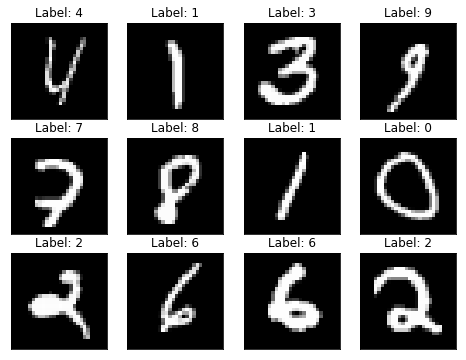

In [0]:
plt.figure(figsize=(8,6))
for i in range(12):

    
    plt.subplot(3,4,i+1)
    plt.imshow(images[i,0,:,:].detach().numpy(), cmap='gray');
    plt.title("Label: " + str(labels[i].item()))
    plt.xticks([], [])
    plt.yticks([], [])    

A Convolution Neural Network (CNN) is a Neural Network that consists of a series of convolution, pooling, and fully connected layers along with non-linear activation functions. CNNs are in particular popular for computer vision applications. In these applications it is common to apply convolution and pooling layers with ever expanding feature maps until the spatial dimension of the feature map is a small fraction of the original input image. 

So for example we start with an input image, followed by a convolution layer, then non-linear activation function, then max pooling, and then repeat this until the feature maps are a fraction of the size input image width and height. Putting it more succinctlywe have 

image -> conv ->ReLU -> MaxPooling -> feature maps

This is applying the convolutional, non-linearity, and Max Pooling operation once. It is more common to repeat this several times:

image -> conv ->ReLU -> MaxPooling -> conv -> ReLU -> MaxPooling -> ... -> featurer maps

Finally at this representation, it is then common to pass through several fully connected layers. It is very common to applying padding to the input image so that the dimension of the convolved image is not changed. We then use Max Pooling to reduce the dimension of the image. 

Below is a concrete example for performing MNIST classification.

In [0]:
class ConvNet(torch.nn.Module):

    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        
        # 28x28x1 => 28x28x8
        # layer takes a tensor of shape 28x28x1
        # and transforms to a 28x28x8 tensor feature map
        self.conv_1 = torch.nn.Conv2d(in_channels=1,
                                      out_channels=8,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=1) 
        
        # 28x28x8 => 14x14x8
        # layer takes a feature maps of shape 28x28x8
        # and down-samples to a set of 14x14x8 feature maps
        self.pool_1 = torch.nn.MaxPool2d(kernel_size=(2, 2),
                                         stride=(2, 2),
                                         padding=0)                                     
        
        # 14x14x8 => 14x14x16
        # layer takes feature maps of shape 14x14x8
        # and transforms to a 14x14x16 tensor feature map        
        self.conv_2 = torch.nn.Conv2d(in_channels=8,
                                      out_channels=16,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=1)               
        # 14x14x16 => 7x7x16  
        # layer takes a feature maps of shape 14x14x16
        # and down-samples to a set of 7x7x16 feature maps        
        self.pool_2 = torch.nn.MaxPool2d(kernel_size=(2, 2),
                                         stride=(2, 2),
                                         padding=0) 


        # fully connected layer that connects 10 output neurons 
        # to every neuron (7*7*16 of them) in the previou feature map
        self.linear_1 = torch.nn.Linear(7*7*16, num_classes)

        
    def forward(self, x):
        # first conv layer
        out = self.conv_1(x)
        # non-linearity
        out = F.relu(out)
        # first pool layer
        out = self.pool_1(out)

        # second conv layer
        out = self.conv_2(out)
        # non-linearity
        out = F.relu(out)
        # second pool layer
        out = self.pool_2(out)
        
        # fully connected layer
        logits = self.linear_1(out.view(-1, 7*7*16))
        
        # normalize as probabilities
        probas = F.softmax(logits, dim=1)
        return logits, probas


Now that we have defined the model architecture , as usual we define instantiate the model and the optimizer. If CUDA is available on our device then we will also off-load the model to the GPU device. 

In [0]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ConvNet(num_classes=10).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=.01)

In [0]:

def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    for features, targets in data_loader:
        features = features.to(device)
        targets = targets.to(device)
        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100
    
   

    
    

In [0]:
num_epochs = 3
for epoch in range(num_epochs):
    model = model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %d/%d | Batch %d/%d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
    
    model = model.eval()
    print('Epoch: %d/%d training accuracy: %.2f%%' % (
          epoch+1, num_epochs, 
          compute_accuracy(model, train_loader)))


Epoch: 1/3 | Batch 0/469 | Cost: 2.3178
Epoch: 1/3 | Batch 50/469 | Cost: 2.2835
Epoch: 1/3 | Batch 100/469 | Cost: 2.2579
Epoch: 1/3 | Batch 150/469 | Cost: 2.2074
Epoch: 1/3 | Batch 200/469 | Cost: 2.0587
Epoch: 1/3 | Batch 250/469 | Cost: 1.7660
Epoch: 1/3 | Batch 300/469 | Cost: 1.1213
Epoch: 1/3 | Batch 350/469 | Cost: 0.6464
Epoch: 1/3 | Batch 400/469 | Cost: 0.5813
Epoch: 1/3 | Batch 450/469 | Cost: 0.4485
Epoch: 1/3 training accuracy: 85.87%
Epoch: 2/3 | Batch 0/469 | Cost: 0.4668
Epoch: 2/3 | Batch 50/469 | Cost: 0.4962
Epoch: 2/3 | Batch 100/469 | Cost: 0.5130
Epoch: 2/3 | Batch 150/469 | Cost: 0.5860
Epoch: 2/3 | Batch 200/469 | Cost: 0.3284
Epoch: 2/3 | Batch 250/469 | Cost: 0.4419
Epoch: 2/3 | Batch 300/469 | Cost: 0.4092
Epoch: 2/3 | Batch 350/469 | Cost: 0.2395
Epoch: 2/3 | Batch 400/469 | Cost: 0.3656
Epoch: 2/3 | Batch 450/469 | Cost: 0.3834
Epoch: 2/3 training accuracy: 89.54%
Epoch: 3/3 | Batch 0/469 | Cost: 0.2646
Epoch: 3/3 | Batch 50/469 | Cost: 0.2110
Epoch: 3/3 

In [0]:


with torch.set_grad_enabled(False):
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Test accuracy: 91.81%


## Transfer Learning

While in the previous section we looked at designing our own CNN architecture, in practice it is far more common to use an existing architecture. As Andrej Karpathy, one of the world experts in neural nets and computer vision, explains: "don't be a hero" and use architectures that have worked will empirically from previous research. 

In addition to using existing architectures, a common training paradigm is to a use a network that was already trained on a large dataset as a starting point. In other words, don't train your network from scratch! Take an existing network that has good performance on a large dataset, and then adjust the weights of this network on your dataset of interest. 

The most common example is take a network that has very good results on the ImageNet dataset and start with the weights trained for that network. ImageNet is a large dataset of images where each image is annotated with labels. Typically most networks that are available publically have been trained on 1 million images with 1000 different non-overlapping categories. It is believed that the diversity of the categories and images provides a good set of samples to learn general features useful for many computer vision tasks. 

In summary, when training your own image classifier (or almost any computer vision task), you should start with a network that has achieved good results on the ImageNet dataset. Fortunately PyTorch provides an easily accessible API for downloading such networks. In the `torchvision` library the `models` module provides many pre-trained networks that we can use for a specific image processing take. 



In [0]:
from torchvision import models


import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time
import os
import copy


The official PyTorch tutorial has an outstanding tutorial on transfer learning that we will follow closely. This tutorial covers the 
two most common approaches of transfer learning:

- Updating and adjusting the weights of the entire network.
- Appending additional layers on top of pre-trained network. Usually only the weights of the newly appended layers are adjusted and the pre-trained network layer weights are kept fixed (also referred to as "frozen"). The idea here is that early layers have already learned useful features and we only need to learn a new mapping for the new classes in our data. 


The task we will cover is the classification of ants vs bees images. The dataset that we will use has about 2400 training images and 150 images for validation. Let's download the dataset:




In [0]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip

!unzip hymenoptera_data.zip

--2019-08-18 21:33:00--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.224.161.47, 13.224.161.79, 13.224.161.121, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.224.161.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip.1’

hymenoptera_data.zi 100%[===================>]  45.10M  28.4MB/s    in 1.6s    

2019-08-18 21:33:02 (28.4 MB/s) - ‘hymenoptera_data.zip.1’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
replace hymenoptera_data/train/ants/0013035.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

As is common in training networks for image classification tasks, we will apply a series of common transformations on images. For training phase, it is common to "augment" the training set with "new" images that are based on slight modifications of the existing images. These slight modifications are minor transformations such as randomly cropping sections of the image, slightly rotating the image etc. 

In our example for the training phase we will do a random crops of 224 pixel wide and height of each image, followed by a random horizontal flip. These transformations make sense: an image of an ant being slightly off-centered (based on the random crop) should still be an ant. Similarly, a horizontal flip of the image of an ant should still be an ant since that is the class of the image. We also normalize each of the image channels based on the image statistics of the ImageNet dataset since we are using an ImageNet pretrained network. For the validation set we do not use random transformations since we want to keep the evaluation of the model fixed. 


In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

We load the image datasets using the `DataLoader` module in PyTorch and specify whether to load a training vs a validation set in a Python dictionary. The `dataloaders` dictionary gives us convenient access with a simple "train" or "val" key to access the respective data loaders. 

In [0]:

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes



As usual we specify which device we want to use and use CUDA if it is available.

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

We also use a convinience function to visualize a sample of images. 

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

The train loop below is the standard training loop that we have seen many times. A nice thing about using dictionaries to store the data loaders is that we can specify if we are in "training phase" or "evaluation phase."

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

For our pre-trained model we will use a ResNet18 [REF] and send to the device. Note that by specifying `pretrained=True` we are using the weights of the network trained on ImageNet. 

In [0]:
model_ft = models.resnet18(pretrained=True).to(device)

We can see the specifics of this architecture by using the summary function from the torchsummary module. summary provides a convenient way of printing a summary of the network architecture.


In [0]:
from torchsummary import summary

In [0]:
summary(model_ft, input_size=(3, 224, 224))

From the print-out of the model we notice that the last layer is a linear layer and it outputs 1000 values. Since this model was trained on ImageNet, these 1000 values correspond to the 1000 categories in ImageNet. Because in our case we only have two categories, bees and ants, we replace this layer to have the same number of inputs but to have 2 outputs instead. 


In [0]:
model_ft.fc = nn.Linear(model_ft.fc.in_features, 2).to(device)

And that is our entire model! As Andrej Karpathy says, when it comes to architecture design, "don't be a hero!" and start with an existing model!

![alt text](https://pbs.twimg.com/media/CtI5p4HUsAAYzNi.jpg)

This is exactly the steps we have done in PyTorch. We have downloaded a per-trained model (in this case a small ResNet to speed up our demo process) and have replaced the output layer.

Now for fine tuning we use the same process as we have before by defining a loss function. We will also decrease the learning rate as this is common practice.

In [0]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [0]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7020 Acc: 0.6270
val Loss: 0.1971 Acc: 0.9346

Epoch 1/24
----------
train Loss: 0.4467 Acc: 0.7992
val Loss: 0.2234 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.4627 Acc: 0.8197
val Loss: 0.2194 Acc: 0.9150

Epoch 3/24
----------
train Loss: 0.6539 Acc: 0.7377
val Loss: 0.3140 Acc: 0.8824

Epoch 4/24
----------
train Loss: 0.3649 Acc: 0.8689
val Loss: 0.3579 Acc: 0.8693

Epoch 5/24
----------
train Loss: 0.4341 Acc: 0.8361
val Loss: 0.3070 Acc: 0.9020

Epoch 6/24
----------
train Loss: 0.3533 Acc: 0.8607
val Loss: 0.2552 Acc: 0.8889

Epoch 7/24
----------
train Loss: 0.2617 Acc: 0.8811
val Loss: 0.2378 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.3291 Acc: 0.8852
val Loss: 0.2302 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.3706 Acc: 0.8689
val Loss: 0.2521 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.3125 Acc: 0.8648
val Loss: 0.2061 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3018 Acc: 0.8811
val Loss: 0.2365 Acc: 0.9281

Ep

Let's visualize how this model predicts:

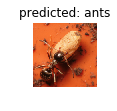

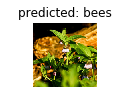

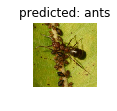

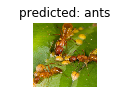

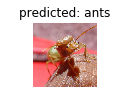

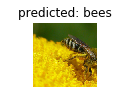

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
        
        
visualize_model(model_ft)        

Let's review what we did here. We were able to train a network with over 11 million parameters on a small dataset of less than 300 images. Without transfer learning, it would be very difficult to learn a good model, but transfer learning from a large dataset has allowed us to train a very useful model!!


Another common approach for transfer learning is "freeze" the earlier layer weights and only change the weights of the last layer. Let's demonstrate how to do this in PyTorch. Again we will download the pre-trained model :


In [0]:
model_conv = torchvision.models.resnet18(pretrained=True)


To freeze the weights of the layers, we iterate through all the parameters of the model and specify that we want the gradients to not be calculated. 

In [0]:
for param in model_conv.parameters():
    param.requires_grad = False

We will now replace the last layer in the network with a new fully connected layer that has 2 outputs (as opposed to the 1000 classes). Since by default when a new layer is module the gradients are calculated (ie,  `requires_grad=True`), when we train only this layer will be updated. 




In [0]:

# Parameters of newly constructed modules have requires_grad=True by default
model_conv.fc = nn.Linear(model_conv.fc.in_features, 2)

model_conv = model_conv.to(device)


And that's it! We can train our model as before!





In [0]:


criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = torch.optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [0]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6327 Acc: 0.6434
val Loss: 0.4435 Acc: 0.8039

Epoch 1/24
----------
train Loss: 0.5390 Acc: 0.7582
val Loss: 0.2905 Acc: 0.8889

Epoch 2/24
----------
train Loss: 0.7289 Acc: 0.7090
val Loss: 0.4438 Acc: 0.8235

Epoch 3/24
----------
train Loss: 0.6355 Acc: 0.7336
val Loss: 0.1593 Acc: 0.9608

Epoch 4/24
----------
train Loss: 0.4916 Acc: 0.8074
val Loss: 0.2487 Acc: 0.9085

Epoch 5/24
----------
train Loss: 0.3395 Acc: 0.8648
val Loss: 0.1764 Acc: 0.9281

Epoch 6/24
----------
train Loss: 0.3443 Acc: 0.8730
val Loss: 0.1961 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.3422 Acc: 0.8525
val Loss: 0.1917 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3322 Acc: 0.8525
val Loss: 0.1846 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3284 Acc: 0.8484
val Loss: 0.2043 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3882 Acc: 0.8320
val Loss: 0.1931 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3947 Acc: 0.8033
val Loss: 0.1964 Acc: 0.9412

Ep

Again when we visualize the results they look very good:

In [0]:
visualize_model(model_conv)

plt.ioff()
plt.show()

## Visualizing CNN filters

Since the 2012 seminal work of Alex Krizhevsky, Illa Sutskever, and Geoff Hinton, CNNs have been enormously popular in computer vision and widely adopted. However, many have noted that training CNNs can still be brittle where errors can occur in unexpected ways. While debugging a system in traditional software engineering has a certain set of procedures, it is not clear how one can debug a machine learning system. Given the complexity of CNNs, it is especially challenging to decipher what are the inner workings of the network.

These issues have motivated many researchers to develop tools to understand what is happening inside in the different layers of the network. Many of the popular visualization methods of CNNs can be broadly categorized into two groups: 1) visualizing how images are transformed after each layer and 2) visualizing what the kernels in the layer are paying “attention” to. 

In the first group, visualizing how image are transformed, it is common to apply a dimensionality reduction technique on a collection of images onto two dimensions and view how the images are scattered. Typically, for a network that has been well trained, the proximity of transformed images in the lower layers may have little in common with each other except for very low level features. For example, bright images may be clustered together, or images with heavy lines, and so on. At deeper layers however, we typically notice that images are grouped together based on the similarity of their content. This suggests that the deeper layers of the network are able to capture higher level features that can be especially useful for object classification. 

The second major type of visualizing CNNs involves the kernels and activations at each layer of the network. Recall that we can think of a kernel as just a small template pattern that are matched against a larger image. If we can visualize what these small template patterns inside the kernels look like, then we can get a sense for what types of features the network is detecting

One way of visualizing the features the network detects is to just visualize the kernels directly by plotting them as heatmaps. While this approach has many drawbacks (especially for deeper layers), it was one of the first attempts at understanding CNNs and caused great excitement due to its similarity of simple cells in the primary visual cortex. In some sense, these visualizations supported the motivation of the CNN architecture taking shape of the visual system in the cerebral cortex. 


Let's visualize what the filters of a CNN model look by loading a pre-trained model. We will consider the classic AlexNet model. 

In [0]:
import torchvision.models as models
cnn = models.alexnet(pretrained=True).features.eval()
print(cnn)

Let's get the filters from the first layer in a list `l` and visualize what these filters look like:

In [0]:
l = [module for module in cnn.modules() if type(module) != nn.Sequential]

kernel = l[0].weight[0].detach().cpu().numpy()
def min_max_kernel(kernel):
    return (kernel - kernel.min())/(kernel - kernel.min()).max()


for i in range(64):
    plt.subplot(8,8,i+1)
    plt.imshow(min_max_kernel(l[0].weight[i].detach().numpy()).T);
    plt.axis('off');

When we visualize the first layer kernels, we see simple patterns resembling different edges. These edges hark back to the edge detectors that were proposed from the Hubel Wiesel experiments. As a rule of thumb, if a CNN network for vision applications does not have such patterns, something is most likely wrong as nearly all real world images, ranging from Memes on the internet to biomedical imagery, require such features. 



## Image Style Transfer

As we learned from visualizing the inner workings of CNNs, we can summarize that earlier layers learn simple low level features while deeper layers learn higher level features. This insight has lead many new applications of CNNs that were not originally thought of. One of these applications is the idea of style transfer. 

Gatys and colleagues [REF] were originally investigating how the representation of images at different layers relate to to the textures in an image. They noticed that when you compute the “second order statistics” of images transformed by a CNN, the different layers capture different levels of texture complexity. These “second order statistics” are computed by the Gramm matrix of the transformed images. The Gramm matrix is just an outer product of the transformed image and is related to the covariance matrix. Another way of thinking about the Gramm matrix is that it is similar to the Covariance matrix but computationally cheaper to compute. 

Intuitively then, by computing the Gramm matrix of the features from a particular layer, we are measuring how much variation there is. But how do we know these variations represent textures? The way Gatys showed this was for a given image to compute the Gramm matrix of the features from a particular layer. Then what we try to do is to *learn a new image* where the Gramm matrix of the features from the same layer of this new image matches our given image. Pictorially, this looks like this:

![alt text](https://upload.wikimedia.org/wikipedia/commons/9/9b/Texture_synthesis.png)

 
Of course the way this image is found is through optimization with Stochastic Gradient Descent. That is, we adjust the gradients of the loss between the generated image features and the actual image features. Here we show what these different synthesized images look like for Van Gogh’s Starry Night:

![alt text](https://pbs.twimg.com/media/EAxXJRtUEAA9Elk?format=jpg&name=small)


What is remarkable is that the images synthesized at the lower layers resemble low dense textures and the higher layers resemble actual brush strokes. At the highest layers what we have look like actual brushstrokes from Van Gogh himself! 

With this insight, Gatys and colleagues realized these Gramm matrices of features from different layers are capturing texture and also the style of an artist. What if we were to try to use the “style” obtained by these features to recreate another image but only with this style? This is the exact idea behind the “Neural Style Transfer” technique. 



In Neural Style Transfer we start with two images: a style image and a content image. The style image can be an image of a painting or an image that has some sort of artistic aesthetic. The content image is a regular photograph that you want to recreate but with the style and aesthetic of the style image. So how can create an image that has the content of the content image but also the style of the style images? We use two loss functions!

We know we can create an image that looks like a content image by using the features from the intermediate layers from the Conv Net. Put another way, if you want to create an image that looks like the content image, first the get features of the content layer from the intermediate layers of a trained CNN. If you have a 5 layer CNN, then you would have 5 sets of features from each layer for the content image. Let’s call these sets of features the “Feature Content Set”.  Now, if you want to create (ie, synthesize) a new image that looks like the content features, this newly synthesized image ought to have very similar features to the Feature Content Set. Graphically this looks like as follows:


In short, what we do is we create a new image (say start with random pixels), then pass this image through the CNN layers. For each of the features extracted from the CNN layers we compute a loss to the respective layer’s Feature Content Set. But what we need is our newly synthesized image to also follow the style of the artist we are interested in. So we will have also have a style loss. 


In our exploration we will closely follow the official Style Transfer Tutorial from PyTorch, but with a twist. While the original Gatys implementation (and the official PyTorch implementation) uses both content loss and a style loss, in our version we will *only* consider a style loss. This provides the benefit of being faster since computing the loss only requires calculating the forward and backward passes. The trick to get to away from abandoning the content loss though is to instead of initialize our synthesized image with white noise, we instead start with the content image itself. Graphically our version of style transfer has the following architecture:

![alt text](https://upload.wikimedia.org/wikipedia/commons/6/6b/Style_transfer.png)


So in our version of Image Style Transfer,  we start with the content image itself and compute the gram features of feature maps produced by the different layers of the pre-trained CNN. The loss then is over these gram features and the gram features of the style feature maps. Based on the loss, we adjust the input content image so it is morphed to have styles that are similar to the style of the artist. 





In [0]:
!git clone https://github.com/myazdani/transfer-this.git

Cloning into 'transfer-this'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 9 (delta 1), reused 8 (delta 0), pack-reused 0
Unpacking objects: 100% (9/9), done.


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image

import torchvision.transforms as transforms
import torchvision.models as models


import matplotlib.pyplot as plt
%matplotlib inline

We first define a helper function for loading an image using the PIL library in Python and transforming to a PyTorch tensor. As usual, we specify if we want to use CUDA or CPU and by default use CUDA if available on our device.  We further specify if we want to use a larger image size if CUDA is available on our system. 


In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)



loader = transforms.Compose([transforms.Resize(imsize), # scale imported image
                             transforms.ToTensor()]) # transform it into a torch tensor


style_img = image_loader("./transfer-this/imgs/starry-night-resize.jpg")
content_img = image_loader("./transfer-this/imgs/Geisel-Library-resized.jpg")


assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

Similarly, we use several helper functions for displaying images.

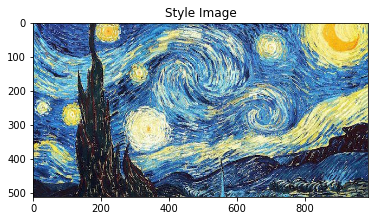

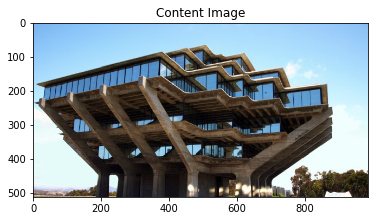

In [0]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

Below is the function for creating the Gram matrix. The gram matrix captures second order statistics, so we could also compute the full covariance matrix to capture notions of texture. However, the Gram matrix is faster to compute and gives sufficiently good results. 

In [0]:
def gram_matrix(input):
    a, b, c, d = input.size()  
    # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

Below is a class that we define for the style loss. It is just the MSE between the Gramm matrix of the input feature maps and target features.

In [0]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

For computing feature, we will use a pre-trained VGG network. As is usual for using pre-trained networks, we also need to specify the normalization that we will use. We will use a module for normalizing the image with the statistics of VGG19.


In [0]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)


# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std
    

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:14<00:00, 40982873.17it/s]


This function will return the model that captures the features of the image and the losses computed based on the style. An important distinction between our model and the original Gatys paper (and the official PyTorch tutorial) is that we do not compute the content losses. 


In [0]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, style_layers):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)


        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses


Finally we have the function that performs the training iterations for creating the image. 






In [0]:
def run_style_transfer(cnn, normalization_mean, normalization_std, 
                       style_img, input_img, style_layers, num_steps=300, 
                       style_weight=1000000):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses = get_style_model_and_losses(cnn, normalization_mean, 
                                                     normalization_std, style_img, 
                                                     style_layers = style_layers)
    optimizer = optim.LBFGS([input_img.requires_grad_()])

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0

            for sl in style_losses:
                style_score += sl.loss

            style_score *= style_weight

            loss = style_score
            loss.backward()

            run[0] += 1
            if run[0] % 100 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} '.format(
                    style_score.item()))
                print()

            return style_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img


Now that we have everything setup, we start with the initial image to be synthesized in the style of Van Gogh’s Starry Night. While the original Gatys paper started with white noise, in our implementation because we are not calculating content losses, we start the initial image itself as the content image. So effectively are performing gradient descent on the content image until it’s style is close to the style of Starry Night. 

In [0]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
#input_img = torch.randn(style_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Initial Image')

NameError: ignored

In [0]:
from torchsummary import summary #cnn.con

In [0]:
conv = nn.Sequential(*list(cnn.children())[:1])

In [0]:
summary(conv, input_img.squeeze().size())

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 987]           1,792
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 5.78
Forward/backward pass size (MB): 246.75
Params size (MB): 0.01
Estimated Total Size (MB): 252.54
----------------------------------------------------------------


In [0]:
input_img_conved = conv(input_img)

In [0]:
input_img_conved.size()

torch.Size([1, 64, 512, 987])

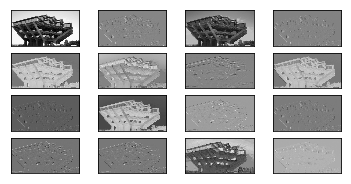

In [0]:
plt.figure(figsize=(6,3))

for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(input_img_conved[0,i,:,:].detach().cpu().numpy(),cmap = "gray")
    plt.xticks([])
    plt.yticks([]);

In [0]:
input_img_grammed = gram_matrix(input_img_conved)

In [0]:
input_img_conved.size()

torch.Size([1, 64, 512, 987])

In [0]:
input_img_grammed

torch.Size([64, 64])

Now we are ready to start off the image creation process. There is one last level of decision we should make. We have to use which layer (that corresponds to different layers) we want to use when creating the image. Here we will use all the convolution layers in VGG19. 

In [0]:
%time
#input_img = torch.randn(style_img.data.size(), device=device)
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
print(style_layers_default)
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            style_img, input_img, num_steps = 1000, 
                            style_weight=1000000,
                            style_layers = style_layers_default)




CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 8.34 µs
['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
Building the style transfer model..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


Optimizing..
run [100]:
Style Loss : 16.044052 

run [200]:
Style Loss : 1.570260 

run [300]:
Style Loss : 0.496723 

run [400]:
Style Loss : 0.255971 

run [500]:
Style Loss : 0.149889 

run [600]:
Style Loss : 0.088549 

run [700]:
Style Loss : 0.055699 



KeyboardInterrupt: ignored

The output image now looks like this.



In [0]:
plt.figure(figsize=(16,16))
imshow(output)

NameError: ignored

<Figure size 1152x1152 with 0 Axes>

## Working with U-Net


The features a CNN learns in image classification are extremely useful for many general computer vision tasks. It appears that each layer learns a different sets of hierarchical features that are transferable for many tasks. One of the questions is which set of layers are more important than others? There have been many studies that suggest certain layers are more transferable than others, but such studies appear to depend on the domain. If we want to be domain agnostic, perhaps we should consider all the features. 
 
The U-Net architecture leverages the utility of the diffeernt features for image segmentation applications by reusing the intermediate features from the hidden convolutional layers. In image segmentation, for a given given image we want to outline the part of the image that belongs to an object. For example, here is an image that we want to segment the different organs: 



![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/b/bd/3D_CT_of_thorax.jpg/240px-3D_CT_of_thorax.jpg)


We may have multiple objects (such as different organs) that we want to segment. The desired output then is to indicate which set of pixels in the image belong to a particular object. The U-Net architecture will have the image as input and as output will produce an image with the same width and height as the input image but with k-channels, where each channel corresponds to a different class of object. Another way of thinking about this k-channel output image is to think of each channel representing the pixels that indicate the xy coordinates of the k-th object. 
 
The U-Net architecture consists of a series of convolution layers where successive layers downsamples the image to an embedding vector (as is typical of CNN architectures). This embedding vector is then up-sampled successively to recreate the same width and height of the input image. So far this architecture can be thought of as an autoencoder, where we first encode (ie, downsample) then decode (ie, upsample). What makes the U-Net different from a traditional autoencoder is that the intermediate features of the CNN layers are used the upsampling process. 



![alt text](https://upload.wikimedia.org/wikipedia/commons/2/2b/Example_architecture_of_U-Net_for_producing_k_256-by-256_image_masks_for_a_256-by-256_RGB_image.png)



We will closely follow an implementation of U-NET provided by Naoto Usuyama (https://github.com/usuyama/pytorch-unet). This implementation is particularly useful for understanding the mechanics of U-Net. In this implementation we generate synthetic images that we want to segment the objects of interest. One of the challenges of learning image segmentation tasks is the availability of high quality segmented images. Because we are generating synthetic images we know exactly where each of the objects of interest are located, therefore for the purposes of understanding how U-Net works this is ideal as it allows us to focus on the model itself and not lack of data issues. 





In [0]:
!git clone https://github.com/usuyama/pytorch-unet.git

Cloning into 'pytorch-unet'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 55 (delta 2), reused 1 (delta 0), pack-reused 48
Unpacking objects: 100% (55/55), done.



To ease the import of helper modules that we need, we rename the repo.

In [0]:
!mv pytorch-unet pytorch_unet

Now we import the `simulation` and `helper` module that will guide our training.  We will also import modules we commonly use.

In [0]:
from pytorch_unet import simulation
from pytorch_unet import helper

import torch
import torch.nn as nn

import os,sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


Let's use the `simulation` module to generate images and view them. We will generate 3 images that are 192 pixels in width and height.  The `simulation` module returns both what the input images should be and their respective target masks. 






In [0]:
# Generate some random images
input_images, target_masks = simulation.generate_random_data(192, 192, count=3)

print("The shape of the input images:", input_images.shape)
print("The min max array values of the input images", 
      input_images.min(), input_images.max())
print("")
print("The shape of the taget masks:", target_masks.shape)
print("The min max array values of the target_masks", 
      target_masks.min(), target_masks.max())




The shape of the input images: (3, 192, 192, 3)
The min max array values of the input images 0 255

The shape of the taget masks: (3, 6, 192, 192)
The min max array values of the target_masks 0.0 1.0


As expected, the input images and the target masks have the same width and height. The input image has 3 channels corresponding to the usual RGB channels and the min and max values of the pixels are between 0 and 255 as is usual for color images. For the target masks however we have **6** channels. Each channel in this case corresponds to a different category and in each channel we specify where the object is located with the pixel value 1 (and 0 everywhere else). As is usual, masks can be thought of as grayscale images that have the value 1.0 where the object is located and 0 everywhere else (in other words, they mask the object in the original from everything else). 


The `helper` module provides us a convenient function for viewing input images and masks. Before viewing them, we have to make sure the images and masks have the proper channel ordering and datatype.





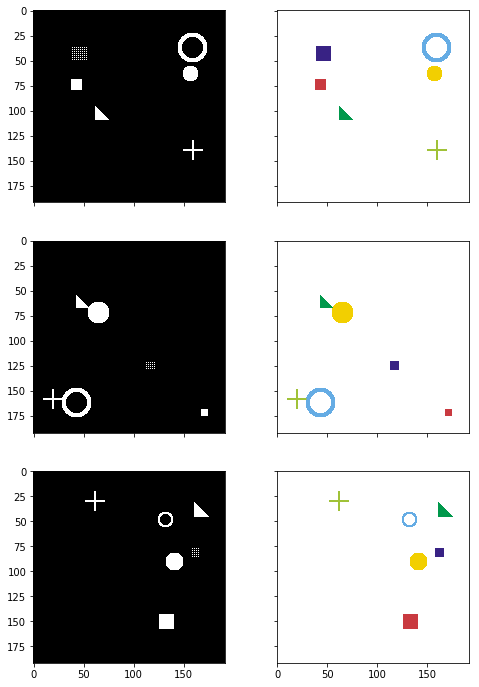

In [0]:
# Change channel-order and make 3 channels for matplot
input_images_rgb = [x.astype(np.uint8) for x in input_images]

# Map each channel (i.e. class) to each color
target_masks_rgb = [helper.masks_to_colorimg(x) for x in target_masks]

# Left: Input image, Right: Target mask (Ground-truth)
helper.plot_side_by_side([input_images_rgb, target_masks_rgb])

We will wrap the images that are generated in `simulation`  in a class that inherits from  `Dataset` so we can use the PyTorch data iterators for training that use `DataLoader`.

We will place the training and validation data loaders in the `data loaders` dictionary where we specify with the `train` or `val` key which dataset we want to access. In our example we will use a batch size of 32 for training. 


In [0]:
####
## data prep

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

class SimDataset(Dataset):
    def __init__(self, count, transform=None):
        self.input_images, self.target_masks = simulation.generate_random_data(192, 192, count=count)        
        self.transform = transform
    
    def __len__(self):
        return len(self.input_images)
    
    def __getitem__(self, idx):        
        image = self.input_images[idx]
        mask = self.target_masks[idx]
        if self.transform:
            image = self.transform(image)
        
        return [image, mask]

# use same transform for train/val for this example
trans = transforms.Compose([
    transforms.ToTensor(),
])

train_set = SimDataset(2000, transform = trans)
val_set = SimDataset(200, transform = trans)

image_datasets = {
    'train': train_set, 'val': val_set
}

batch_size = 32

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in image_datasets.keys()
}

dataset_sizes

{'train': 2000, 'val': 200}

In [0]:

# import torchvision.utils

# def reverse_transform(inp):
#     '''make the tensor numpy and matplotlib friendly
#     '''
#     inp = inp.numpy().transpose((1, 2, 0))
#     inp = np.clip(inp, 0, 1)
#     inp = (inp * 255).astype(np.uint8)
    
#     return inp

# # Get a batch of training data
# inputs, masks = next(iter(dataloaders['train']))

# print(inputs.shape, masks.shape)
# for x in [inputs.numpy(), masks.numpy()]:
#     print(x.min(), x.max(), x.mean(), x.std())

# plt.imshow(reverse_transform(inputs[3]))

We will now define the U-Net architecture. Since in the U-Net after every convolution we follow by a non-linear activation function, we create a custom layer called `cov_nonlinear` that does just that. Since we do not want the convolution layers to change the shape of the image, we use a padding of 1 for the kernel size of 3.  In the comments we show how the network shape specifics. 


In [0]:
def conv_nonlinear(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)       
    )  

class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
                
        self.dconv_down1 = conv_nonlinear(3, 64)
        self.dconv_down2 = conv_nonlinear(64, 128)
        self.dconv_down3 = conv_nonlinear(128, 256)
        self.dconv_down4 = conv_nonlinear(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', 
                                    align_corners=True)        
        
        self.dconv_up3 = conv_nonlinear(256 + 512, 256)
        self.dconv_up2 = conv_nonlinear(128 + 256, 128)
        self.dconv_up1 = conv_nonlinear(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        # (3, 192, 192) -> (64, 192, 192)
        conv1 = self.dconv_down1(x)
        
        # (64, 96, 96) -> (64, 96, 96) 
        x = self.maxpool(conv1)
        
        # (64, 96, 96) -> (128, 96, 96)
        conv2 = self.dconv_down2(x)
        # (128, 96, 96) -> (128, 48, 48) 
        x = self.maxpool(conv2)
        
        #  (128, 48, 48) -> (256, 48, 48)
        conv3 = self.dconv_down3(x)
        
        # (256, 48, 48) -> ( 256, 24, 24)
        x = self.maxpool(conv3)   
        
        # ( 256, 24, 24) -> (512, 24, 24)
        x = self.dconv_down4(x)
        
        
        # (512, 24, 24) -> (512, 48, 48)
        x = self.upsample(x)        
        # (512, 48, 48) x (256, 48, 48) ->  (768, 48, 48)
        x = torch.cat([x, conv3], dim=1)
        
        # (768, 48, 48) -> (256, 48, 48)
        x = self.dconv_up3(x)
        # (256, 48, 48) -> (256, 96, 96)
        x = self.upsample(x)        
        
        # (256, 96, 96) x (128, 96, 96) -> (384, 96, 96)
        x = torch.cat([x, conv2], dim=1)       
        # (384, 96, 96) -> (128, 96, 96)
        x = self.dconv_up2(x)
        # (128, 96, 96) -> (128, 192, 192)
        x = self.upsample(x)        
        # (128, 192, 192) x (64, 192, 192) -> (192, 192, 192) 
        x = torch.cat([x, conv1], dim=1)   
        # (192, 192, 192)  -> (64, 192, 192)
        x = self.dconv_up1(x)
        # (64, 192, 192) -> (6, 192, 192)
        out = self.conv_last(x)
        
        return out


We now define the loss function for the segmentation task. We have a number of options for computing the segmentation loss. One option is to use the MSE between the target mask and the output of the network. A problem with this approach, however, is that the target masks correspond to specific categories, so a categorical-based loss would be more desirable. The binary cross entropy loss is typically used for such cases and we will use that here.

In addition to the binary cross entropy loss, in image segmentation tasks it is also common to use the Dice loss (named after one of the inventors of the Dice coefficient). The Dice loss is based on the intersection if the prediction of the mask and the target masks with a normalization. Since we would like our prediction masks to have maximal match with the target masks (and indeed the purpose of masks is to mask the objects of interest), the Dice is particularly useful. A drawback of the Dice loss, unlike binary cross entropy, is that because it is based on a hard intersection between the prediction and target, we may be obtaining sparse gradient information.

Here we will use BOTH the Dice loss and the binary cross entropy loss to get the best of both worlds. We can just compute both and have a weighted sum between the two. The weighting is an additional hyper-parameter that can be fine tuned. 

In [0]:

from collections import defaultdict
import torch.nn.functional as F



def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()


def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
        
    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)
    
    loss = bce * bce_weight + dice * (1 - bce_weight)
    
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss



Now that we have defined the loss functions and the network architecture, we define the usual training function.




In [0]:
def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)             

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))    



In [0]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet(6)
model = model.to(device)


In [0]:
import torch.optim as optim
from torch.optim import lr_scheduler
import copy
import time

In [0]:
# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=25, gamma=0.1)

model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=40)

Epoch 0/39
----------
LR 0.0001
train: bce: 0.220425, dice: 0.994949, loss: 0.607687
val: bce: 0.030718, dice: 0.988511, loss: 0.509614
saving best model
1m 4s
Epoch 1/39
----------
LR 0.0001
train: bce: 0.021679, dice: 0.825266, loss: 0.423472
val: bce: 0.016376, dice: 0.685955, loss: 0.351165
saving best model
1m 4s
Epoch 2/39
----------
LR 0.0001
train: bce: 0.013096, dice: 0.517510, loss: 0.265303
val: bce: 0.012145, dice: 0.379221, loss: 0.195683
saving best model
1m 5s
Epoch 3/39
----------
LR 0.0001
train: bce: 0.011742, dice: 0.319626, loss: 0.165684
val: bce: 0.009782, dice: 0.258825, loss: 0.134304
saving best model
1m 5s
Epoch 4/39
----------
LR 0.0001
train: bce: 0.009549, dice: 0.240911, loss: 0.125230
val: bce: 0.008249, dice: 0.198129, loss: 0.103189
saving best model
1m 5s
Epoch 5/39
----------
LR 0.0001
train: bce: 0.007334, dice: 0.186069, loss: 0.096702
val: bce: 0.006019, dice: 0.158353, loss: 0.082186
saving best model
1m 5s
Epoch 6/39
----------
LR 0.0001
train: b

Now that we have trained the model lets view some of the outputs of the segmentation tasks:

(3, 6, 192, 192)


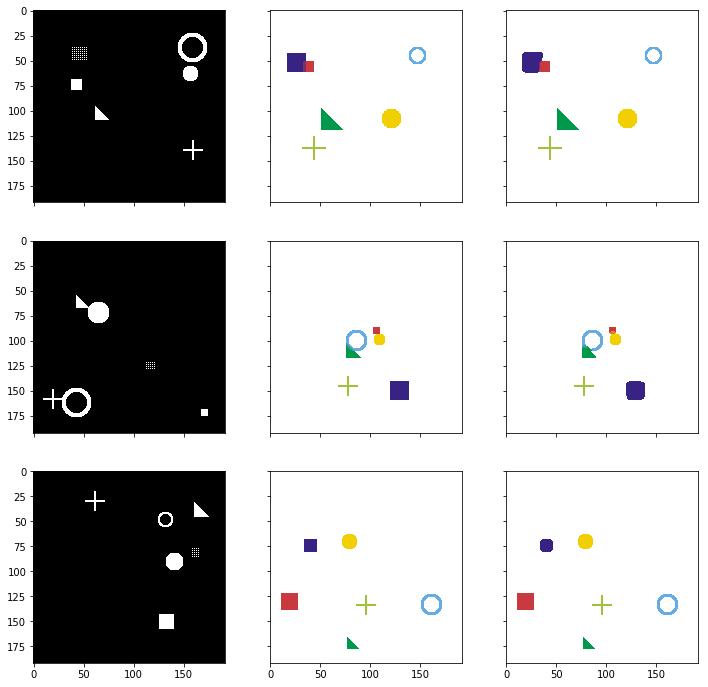

In [0]:
import math

model.eval()   # Set model to evaluate mode

test_dataset = SimDataset(3, transform = trans)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, num_workers=0)
        
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)

pred = model(inputs)

pred = pred.data.cpu().numpy()
print(pred.shape)

# def reverse_transform(inp):
#     '''make the tensor numpy and matplotlib friendly
#     '''
#     inp = inp.numpy().transpose((1, 2, 0))
#     inp = np.clip(inp, 0, 1)
#     inp = (inp * 255).astype(np.uint8)
    
#     return inp

# # Change channel-order and make 3 channels for matplot
input_images_rgb = [x.astype(np.uint8) for x in input_images]

# # Map each channel (i.e. class) to each color
# target_masks_rgb = [helper.masks_to_colorimg(x) for x in target_masks]

# # Left: Input image, Right: Target mask (Ground-truth)
# helper.plot_side_by_side([input_images_rgb, target_masks_rgb])


# Map each channel (i.e. class) to each color
target_masks_rgb = [helper.masks_to_colorimg(x) for x in labels.cpu().numpy()]
pred_rgb = [helper.masks_to_colorimg(x) for x in pred]

helper.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

## Solving the Adding problem with CNNs